In [1]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.types import *

In [2]:
def flat_map_mean_temp(line):
    data = line.split(',')
    to_return = []
    for month, d in enumerate(data):
        if (month > 0):
            to_return.append((int(data[0]) + month/100, float(d)))
    return to_return
mean_temp_RDD = sc.textFile("./data/24_hour_temp_mean.csv")\
                    .flatMap(flat_map_mean_temp)
#mean_temp_RDD.collect()

In [3]:
def map_monthly_average(line):
    year_and_other = line.split('M')
    month_and_rainy_days = year_and_other[1].split('^^')
    year_month = int(year_and_other[0])+int(month_and_rainy_days[0])/100
    rainy_days = float(month_and_rainy_days[1])
    return (year_month, rainy_days)

In [4]:
rainy_days_RDD = sc.textFile("./data/num_of_rainy_days.txt")\
                        .map(map_monthly_average)
rainfall_one_day_max_RDD = sc.textFile("./data/rainfall_one_day_max.txt")\
                                .map(map_monthly_average)
daily_sunshine_average_RDD = sc.textFile("./data/sunshine_daily_mean.txt")\
                                .map(map_monthly_average)
max_temp_mean_RDD = sc.textFile("./data/temp_mean_max.txt")\
                                .map(map_monthly_average)
min_temp_mean_RDD = sc.textFile("./data/temp_mean_min.txt")\
                                .map(map_monthly_average)
total_rainfall_RDD = sc.textFile("./data/total_monthly_rainfall.txt")\
                                .map(map_monthly_average)

In [5]:
bad_RDD =  rainy_days_RDD\
                .join(mean_temp_RDD)\
                .join(rainfall_one_day_max_RDD)\
                .join(daily_sunshine_average_RDD)\
                .join(max_temp_mean_RDD)\
                .join(min_temp_mean_RDD)\
                .join(total_rainfall_RDD)

In [6]:
# TODO: get rid of this hardcoded solution
def fix_bad(data):
    return (data[0]*100%100, 
            data[1][0][0][0][0][0][0], 
            data[1][0][0][0][0][0][1], 
            data[1][0][0][0][0][1], 
            data[1][0][0][0][1],
            data[1][0][0][1], 
            data[1][0][1], 
            data[1][1])

In [7]:
collected_data_RDD = bad_RDD.map(fix_bad)

In [8]:
schemaString = "month days_of_rain mean_temp rainfall_one_day_max daily_sunshine_average max_temp_mean min_temp_mean total_rainfall"
fields = [StructField(field_name, DoubleType(), True) for field_name in schemaString.split()]
schema = StructType(fields)
df = sqlContext.createDataFrame(collected_data_RDD, schema)

In [9]:
# months where it rained over 10 days
df.filter(df.days_of_rain > 10).count()


57

In [10]:
pandas_df = df.toPandas()

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

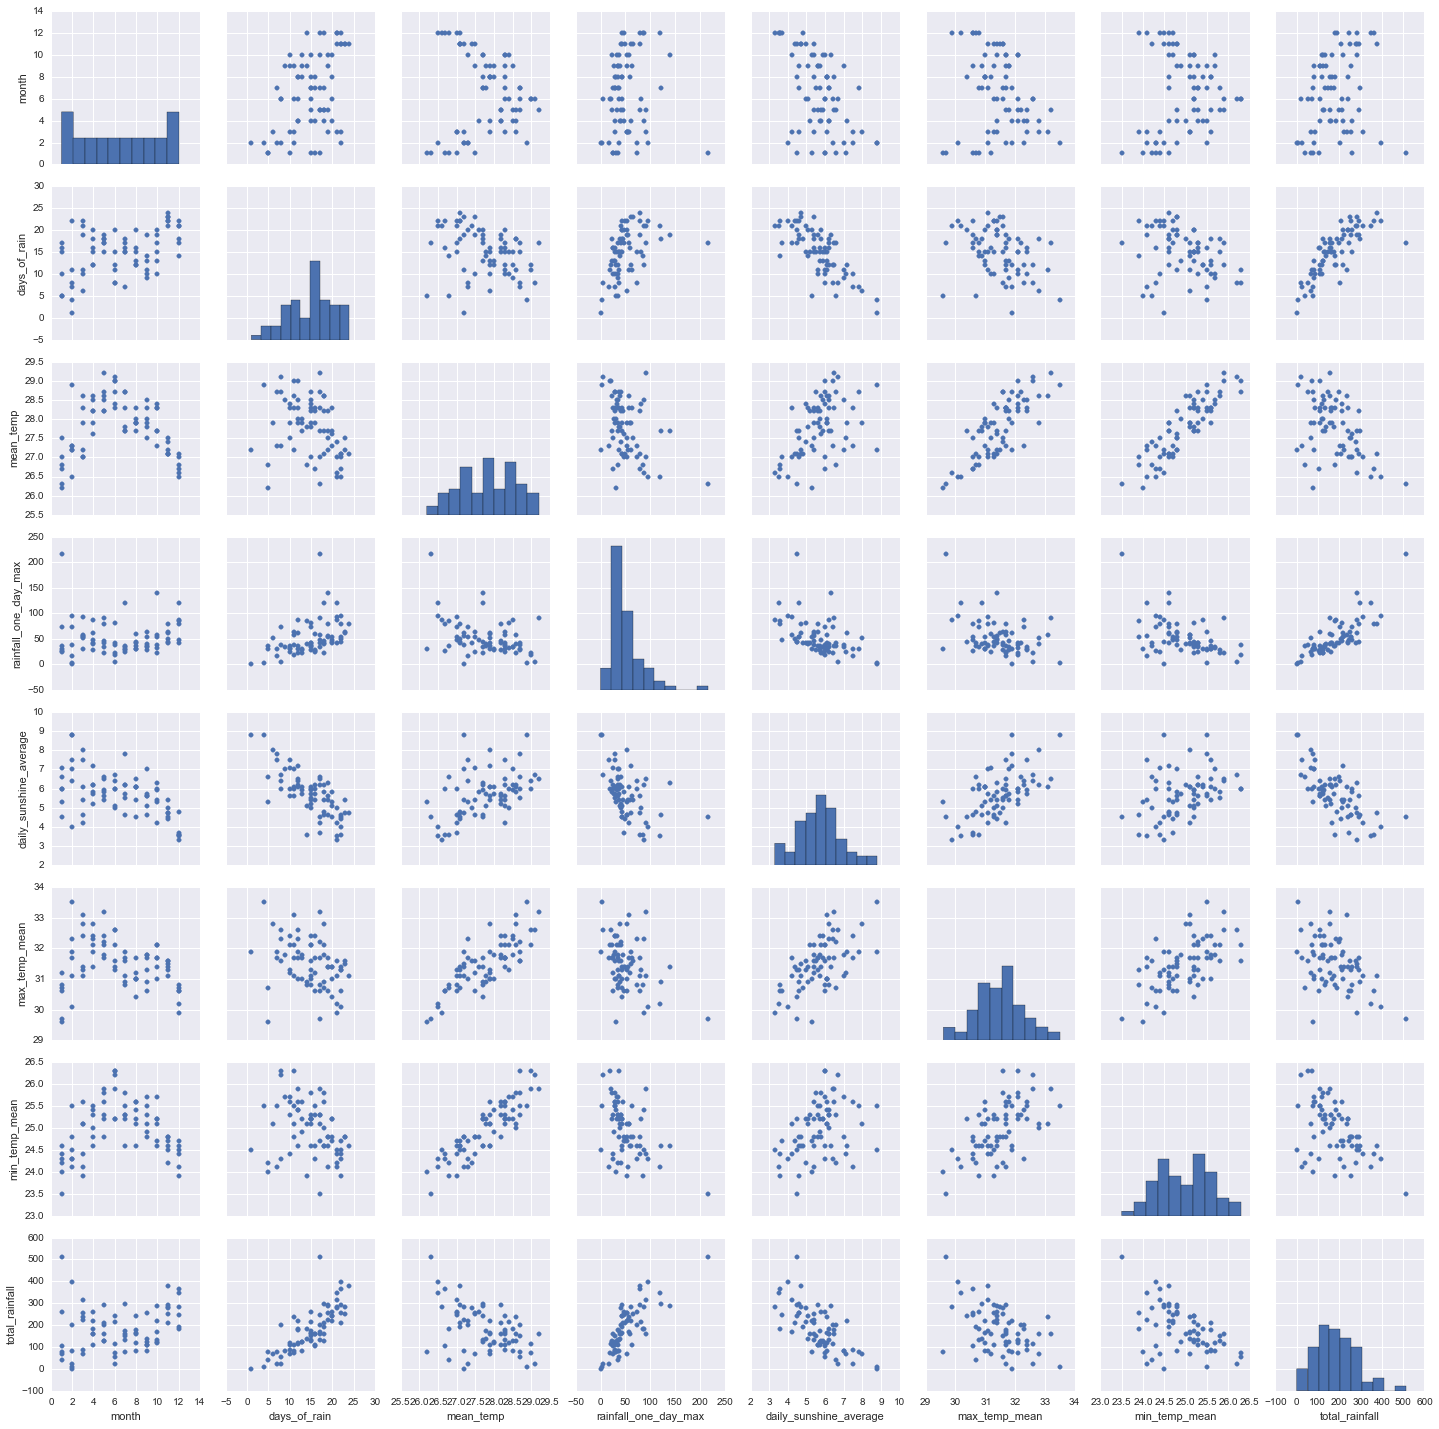

In [12]:
sb.pairplot(pandas_df)

In [13]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

reduced_numeric_cols = schemaString.split()
reduced_numeric_cols.remove('days_of_rain')

assembler = VectorAssembler(
    inputCols = reduced_numeric_cols,
    outputCol = 'features')

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

classifier = LinearRegression(labelCol = 'days_of_rain', featuresCol = 'features')
pipeline = Pipeline(stages=[assembler, classifier])

(training_data, test_data) = df.randomSplit([0.9, 0.1])
model = pipeline.fit(training_data)

In [15]:
predictions = model.transform(test_data)

/usr/local/Cellar/apache-spark/1.6.1/libexec/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [16]:
predictions.select("prediction", "days_of_rain", "features").show()

+------------------+------------+--------------------+
|        prediction|days_of_rain|            features|
+------------------+------------+--------------------+
|17.132882667696013|        18.0|[5.0,28.2,46.0,5....|
|14.327307279734715|        14.0|[9.0,27.8,40.0,5....|
|14.196718593404146|        18.0|[5.0,28.6,22.4,5....|
|15.106793562096215|        16.0|[7.0,28.3,24.4,6....|
| 7.829805852888814|        10.0|[1.0,27.5,25.0,7....|
|13.893242354588555|        16.0|[8.0,27.9,60.0,5....|
+------------------+------------+--------------------+



In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="days_of_rain", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
rfModel = model.stages[1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 2.05223
LinearRegression_4b8eb019aa735b6bb489
